In [1]:
import os; import pathlib as pl ; import flopy ; import git ; import matplotlib.pyplot as plt ; import pandas as pd 
import numpy as np ; from flopy.plot.styles import styles  ; from modflow_devtools.misc import get_env, timed ; from pathlib import Path
import matplotlib as mpl; import csv; from shapely.geometry import Polygon; from flopy.utils.gridintersect import GridIntersect

In [2]:
sim_name = "ex-gwf-fhb" ; output_folder = Path("./05_ex-gwf-fhb") ; output_folder.mkdir(exist_ok=True) 
parameter_units = {"recharge": "$ft/s$"}  ; length_units = "feet"  ; time_units = "seconds" 
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = output_folder  ; figs_path = output_folder ;gwf_name = sim_name 
output_folder2 = output_folder/sim_name

In [3]:
length_units = "meters" ; nper = 3 ;  nlay = 1 ;  ncol = 10 ;  nrow = 3 ;  delr = 1000 ;  delc = 1000 ;  top = 50 ;  
time_units = "days" ; botm_str = "-200.0" ;  strt = 0 ;  icelltype_str = "0" ;  k11_str = "20.0" ;  ss = 0.01 ;  
perlen = [400.0,200.0,400.0] ;  nstp = [10,4,6] ;  tsmult = [1.0,1.0,1.0] ;  tdis_ds = list(zip(perlen,nstp,tsmult)) ;  
nouter = 50 ;  ninner = 100 ;  hclose = 0.000000001 ;  rclose = 0.000001 ;  
botm = [float(value) for value in botm_str.split(",")]
k11 = [float(value) for value in k11_str.split(",")]
icelltype = [int(value) for value in icelltype_str.split(",")]

In [4]:
print('tdis_ds    ',tdis_ds)

tdis_ds     [(400.0, 10, 1.0), (200.0, 4, 1.0), (400.0, 6, 1.0)]


In [5]:
sim_ws = os.path.join(workspace, sim_name)
sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
flopy.mf6.ModflowIms(sim,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
flopy.mf6.ModflowGwfnpf(gwf,icelltype=icelltype,k=k11,save_specific_discharge=True,)
flopy.mf6.ModflowGwfic(gwf,strt=strt)
flopy.mf6.ModflowGwfsto(gwf,storagecoefficient=True,iconvert=0,ss=1.0e-6,sy=None,transient={0:True},)

chd_spd=[] ; chd_spd+=[[0,i,9,"CHDHEAD"]for i in range(3)] ; chd_spd={0:chd_spd}  
tsdata=[(0.0,0.0),(307.0,1.0),(791.0,5.0),(1000.0,2.0)]
tsdict={"timeseries":tsdata,"time_series_namerecord":"CHDHEAD","interpolation_methodrecord":"LINEAREND"}  
flopy.mf6.ModflowGwfchd(gwf,stress_period_data=chd_spd,timeseries=tsdict,pname="CHD",)                    ; tsdataCHD= tsdata

wel_spd=[] ; wel_spd+=[[0,1,0,"FLOWRATE"]] ; wel_spd={0:wel_spd}
tsdata=[(0.0,2000.0),(307.0,6000.0),(791.0,5000.0),(1000.0,9000.0)]
tsdict={"timeseries":tsdata,"time_series_namerecord":"FLOWRATE","interpolation_methodrecord":"LINEAREND"}
flopy.mf6.ModflowGwfwel(gwf,stress_period_data=wel_spd,timeseries=tsdict,pname="WEL")                     ; tsdataWel= tsdata

head_filerecord=f"{sim_name}.hds" ; budget_filerecord=f"{sim_name}.cbc" ; 

#flopy.mf6.ModflowGwfoc(gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD","ALL"),("BUDGET","ALL")])
flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=f"{sim_name}.hds",budget_filerecord=f"{sim_name}.bud",
                          headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                            saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])   

obsdict={} ; obslist=[["h1_2_1","head",(0,1,0)],["h1_2_10","head",(0,1,9)]]   ; obsdict[f"{sim_name}.obs.head.csv"]=obslist
obslist=[["icf1","flow-ja-face",(0,1,1),(0,1,0)]]                             ; obsdict[f"{sim_name}.obs.flow.csv"]=obslist  

obs=flopy.mf6.ModflowUtlobs(gwf,print_input=False,continuous=obsdict)
sim.write_simulation(silent=True)  ; sim.run_simulation(silent=True)  

(True, [])

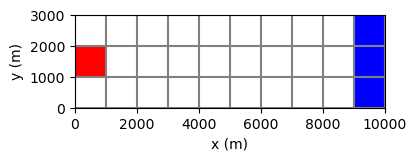

In [6]:
fig = plt.figure(figsize=(4, 3.0)) ; fig.tight_layout()   ; ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)   ; pmv.plot_grid()      ; pmv.plot_bc(name="CHD",color="blue") ; pmv.plot_bc(name="WEL") 
ax.set_xlabel("x (m)") ; ax.set_ylabel("y (m)") ; plt.show()

In [7]:
obsnames = gwf.obs.output.obs_names    # ; obs_list = [gwf.obs.output.obs(f=obsnames[0]),    gwf.obs.output.obs(f=obsnames[1])]
print('obsnames:  ', obsnames)

obsnames:   ['ex-gwf-fhb.obs.head.csv', 'ex-gwf-fhb.obs.flow.csv']


In [8]:
tsdata1  = gwf.obs.output.obs(f=obsnames[0])  ; ts1 = tsdata1.data ; ts1na = ts1.dtype.names[1:] ; print('ts.names_   ts1:',ts1na) 
tsdata2  = gwf.obs.output.obs(f=obsnames[1])  ; ts2 = tsdata2.data ; ts2na = ts2.dtype.names[1:] ; print('ts.names_   ts2:',ts2na) 

ts.names_   ts1: ('H1_2_1', 'H1_2_10')
ts.names_   ts2: ('ICF1',)


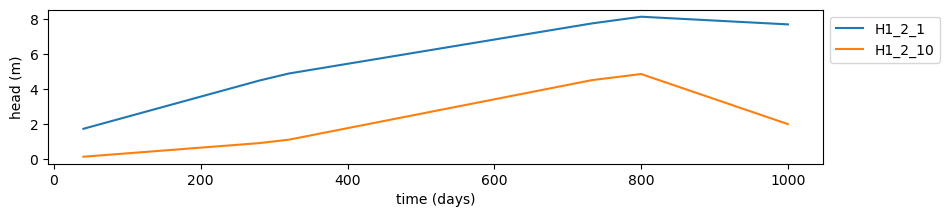

In [9]:
df = pd.DataFrame(ts1); ax = df.plot(x="totim", y= list(ts1na) , kind="line", rot=0, figsize=(10,2)); 
ax.legend(bbox_to_anchor=(1.0, 1.0)); ax.set(xlabel="time (days)", ylabel="head (m)"); plt.show()

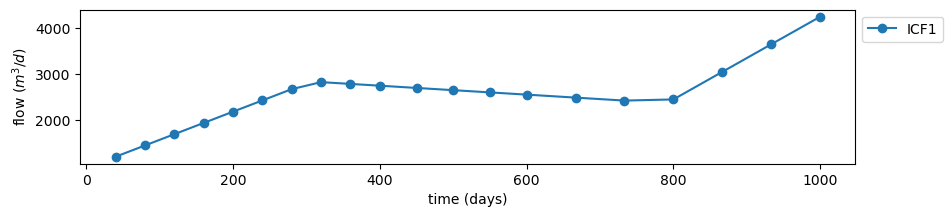

In [10]:
df = pd.DataFrame(ts2); ax = df.plot(x="totim", y= list(ts2na) , kind="line",marker = 'o', rot=0, figsize=(10,2)); 
ax.legend(bbox_to_anchor=(1.0, 1.0)); ax.set(xlabel="time (days)", ylabel="flow ($m^3/d$)"); plt.show()
np.savetxt(output_folder / "a_.csv", df, delimiter=",")

In [11]:
fname = os.path.join (output_folder2/ f"{sim_name}.hds")    
hdobj = flopy.utils.HeadFile(fname); headsA=hdobj.get_data() ; headsB=headsA[0,:,:] ;tn=pd.DataFrame(headsB) ;tn.to_csv(output_folder/"c_H_2d.csv")
print(headsA.shape) 

(1, 3, 10)


In [12]:
hobj = gwf.output.head()    ; hds = hobj.get_data()                      ; print('H (2000d) = ', hds      .shape)
cobj = gwf.output.budget()  ; spd = cobj.get_data(text="DATA-SPDIS")[0]  ; print('Q (2000d) = ', spd      .shape) 

H (2000d) =  (1, 3, 10)
Q (2000d) =  (30,)


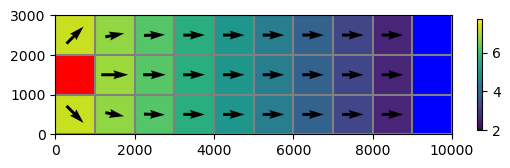

In [13]:
mm = flopy.plot.PlotMapView(model=gwf, layer=0, extent=gwf.modelgrid.extent) ; 
cbv = mm.plot_array(hds); q = mm.plot_vector(spd["qx"], spd["qy"]) ;  cb = plt.colorbar(cbv, ax=mm.ax, shrink=.3)
mm.plot_grid()      ; mm.plot_bc(name="CHD",color="blue" )     ; mm.plot_bc(name="WEL")

## **x,y = distancies (m)**

In [14]:
sv = hds.reshape(hds.shape[0],-1)  ; then=pd.DataFrame(sv)  ; then.to_csv (output_folder / 'b_H_xy.csv' )  ; print('sv_HDS   ', sv.shape)
sv_2D = hds.reshape(ncol , nrow)  ; print('sv_HDS_2D', sv.shape)

sv_HDS    (1, 30)
sv_HDS_2D (1, 30)


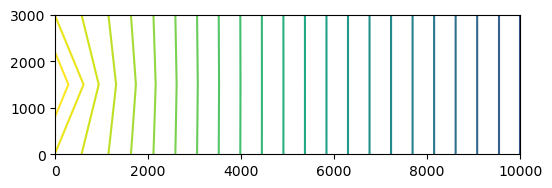

In [15]:
fig = plt.figure(figsize=(6, 6)) ; ax = fig.add_subplot(1, 1, 1, aspect="equal"); ll=90
ax.contour(hds[0,:,:],  levels=np.arange(0,   np.percentile(sv,99.9)    ,0.25) ,  extent = gwf.modelgrid.extent) ; plt.show()

## **x,y = distancies (m)**

In [16]:
perlen = [400.0,200.0,400.0] ;  nstp = [10,4,6] ;  tsmult = [1.0,1.0,1.0] ;  tdis_ds = list(zip(perlen,nstp,tsmult)) 
print('tdis_ds    ',tdis_ds) ; print('sum(perlen)', np.sum(perlen))
#a1=list(map(lambda x: perlen[x],[0])); a2=list(map(lambda x: nstp[x],[0])); a3=list(map(lambda x: tsmult[x],[0])) ; a1, a2, a3
#list(map(lambda x:  tdis_ds[x],[0]))  

tdis_ds     [(400.0, 10, 1.0), (200.0, 4, 1.0), (400.0, 6, 1.0)]
sum(perlen) 1000.0


In [17]:
b1=np.linspace(0,400,num=10,endpoint=True) ;b2=np.linspace(400,600,num=4,endpoint=True) ; b3=np.linspace(600,1000,num=6,endpoint=True); b1,b2,b3
np.savetxt(output_folder / "d_timprs.csv", np.concatenate((b1, b2, b3)), delimiter=",")

**starts at 40, why?**

In [18]:
times = hobj.get_times()    ;  print('bj = gwf.output.head() ... times', times)
np.savetxt(output_folder / "e_times.csv", times, delimiter=",")

bj = gwf.output.head() ... times [40.0, 80.0, 120.0, 160.0, 200.0, 240.0, 280.0, 320.0, 360.0, 400.0, 450.0, 500.0, 550.0, 600.0, 666.6666666666666, 733.3333333333333, 799.9999999999999, 866.6666666666665, 933.3333333333331, 1000.0]


**Where are the times here ? ... , already identifield at df = pd.DataFrame(ts2) ...**

In [19]:
print('tsdataCHD', tsdataCHD) ; print('');  print('tsdataWel', tsdataWel)

np.savetxt(output_folder / "f_tsdataCHD.csv", tsdataCHD, delimiter=",")
np.savetxt(output_folder / "g_tsdataWel.csv", tsdataWel, delimiter=",")

tsdataCHD [(0.0, 0.0), (307.0, 1.0), (791.0, 5.0), (1000.0, 2.0)]

tsdataWel [(0.0, 2000.0), (307.0, 6000.0), (791.0, 5000.0), (1000.0, 9000.0)]
